## 1. Prepare the environment

### Optional: download all the python libraries if you not already present in the environment

In [1]:
! python.exe -m pip install --upgrade pip
! pip install --upgrade moku
! pip install zeroconf
! moku download --fw_ver=601
%pip install --q moku[neuralnetwork]


/bin/sh: python.exe: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.4 MB/s eta 0:00:00
Moku Client - *** Deprecating soon, use mokucli ***
[##############################] Done!
Verifying download..
Download complete
Note: you may need to restart the kernel to use updated packages.


### Import the Python libraries

In [2]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import moku
import numpy as np
import os
from pathlib import Path
import time


In [3]:
from moku.instruments import MultiInstrument
from moku.instruments import WaveformGenerator, PIDController

try:
    from moku.nn import LinnModel, save_linn
except ImportError:
    print("Moku library is not installed.")
    print("If you're running in a Notebook like Google Colab, uncomment the first line in this cell and run it again")
    print("Otherwise install the moku library with neural network extensions using `pip install moku[neuralnetwork]`")
    raise

2025-05-22 01:21:54.876825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747876914.912011   30510 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747876914.922537   30510 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747876914.947679   30510 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747876914.947712   30510 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747876914.947715   30510 computation_placer.cc:177] computation placer alr

### List the available moku devices

In [4]:
! mokucli list

Name                 Serial  HW     FW     IP                  
---------------------------------------------------------------
MokuGo-004186        4186    Go     602    fe80::7269:79ff:feb9:4168%17
MokuLab-002094       2094    Lab    606    fe80::72b3:d5ff:fe87:b82e%17
MokuGo-000051        51      Go     606    fe80::7269:79ff:feb9:cc%17
MokuPro-000323       323     Pro    601    fe80::7269:79ff:feb0:570%17


In [8]:
# Replace in the code below the first input variable with your Moku IP adrress and platform id based on your Moku
m = MultiInstrument('[fe80::7269:79ff:feb0:570%17]', platform_id=4, force_connect=True)

## 2. Set up the Multi-instrument

In [ ]:
''' Pick one instrument per slot
    In the first slot we will insert a waveform generator to geenrate the noisy sine waveform
    In the second slot we will insert a PID controller to combine the pulse (anomaly) with the noisy sine waveform
    In the forth and last slot we will insert another waveform geenrator to reproduce the anomaly/glitch as a pulse. 

'''
wg = m.set_instrument(1, WaveformGenerator)
pidc = m.set_instrument(2, PIDController)
wgmod = m.set_instrument(4, WaveformGenerator)

connections = [dict(source="Slot4OutA", destination="Slot1InA"),
                dict(source="Slot4OutB", destination="Slot1InB"),
                dict(source="Slot1OutA", destination="Slot2InA"),
                dict(source="Slot1OutB", destination="Slot2InB"),
                dict(source="Slot2OutA", destination="Output1")] # This is our output from the PID controller that will be saved in the variable data. 


### 2.1 Set up the instruments

In [342]:
# Generate the noisy sine waveform using the waveform generator on slot 1 
wg.generate_waveform(channel=1, type="Sine", frequency=100, amplitude=1.0)
wg.generate_waveform(channel=2, type='Noise', amplitude=1.0)
wg.set_modulation(channel=2, type="Amplitude", source="InputB", depth=1000)

# Generate the pulse signal (our anomaly) from the waveform generator on slot 4.
wgmod.generate_waveform(channel=2, type="Pulse", frequency=50, amplitude=1, offset=410e-3, pulse_width=1e-6, edge_time=2e-9)

# Set up the PID controller parameters to combine the noisy sine waveform and pulse signal. We will increase the pulse amplitude by 10 (see control matrix)
pidc.set_control_matrix(channel=1, input_gain1=1, input_gain2=10)
pidc.set_control_matrix(channel=2, input_gain1=0, input_gain2=0)
pidc.set_by_frequency(channel=1, prop_gain=0) # Set up the gain to 0
pidc.set_by_gain(channel=2, prop_gain=0) # Set up the gain to 0


pidc.enable_output(1, signal=True, output=True) # Only enable this output from the PID controller
pidc.enable_output(2, signal=True, output=False)

pidc.set_monitor(monitor_channel=1, source="Output1")
pidc.set_acquisition_mode(mode="PeakDetect") # This can also be set to 'precision'
pidc.set_timebase(-15e-3, 15e-3)

{'t1': -0.015, 't2': 0.015}

### 2.2 Get the data from the PID controller and save it to local

In [343]:
# Output filenames
output_folder = "moku_data_AD/"
output_filename = "moku_data_anomaly50"

timestamp = str(time.time()).split(".")[-1]

output_filename = f"{output_folder}{output_filename}_{timestamp}.csv"
print(f"Data will be saved in the file: {output_filename}" )


# If the folder doesn't exist it, create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Folder created: {output_folder}")
else:
    print(f"Folder already exists: {output_folder}")


Data will be saved in the file: moku_data_AD/moku_data_anomaly50_64076.csv
Folder already exists: moku_data_AD/


In [ ]:
def append_list_to_csv(data_list, filename):
    
    # Check if file exists
    file_exists = os.path.isfile(filename)
    print(file_exists)

    if not file_exists:
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(data_list)

    else:
        # Open the file in append mode
        with open(filename, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(data_list)

    

## Error!- if peakPetect it needs to save both ch1 and ch2

In [345]:
n_frames = 10
for i in range(n_frames):
    data = pidc.get_data() # Get the data from the PID controller


    # Set up the plotting parameters
    '''plt.ion()
    plt.show()
    plt.ylim([-2, 2])
    plt.xlim([data['time'][0], data['time'][-1]])

    line1, = plt.plot([])
    line2, = plt.plot([])

    # Configure labels for axes
    ax = plt.gca()'''

    # This loops continuously updates the plot with new data

    data = pidc.get_data()
    print(f'{i} - Saved {len(data["ch1"])} points from the PID controller')
    append_list_to_csv(data["ch1"], filename=output_filename)

    # Update the plot
    '''line1.set_ydata(data['ch1'])
    line1.set_xdata(data['time'])'''

0 - Saved 1024 points from the PID controller
False
1 - Saved 1024 points from the PID controller
True
2 - Saved 1024 points from the PID controller
True
3 - Saved 1024 points from the PID controller
True
4 - Saved 1024 points from the PID controller
True
5 - Saved 1024 points from the PID controller
True
6 - Saved 1024 points from the PID controller
True
7 - Saved 1024 points from the PID controller
True
8 - Saved 1024 points from the PID controller
True
9 - Saved 1024 points from the PID controller
True


In [5]:
def load_csv_as_list(filename):
    data = []
    with open(filename, mode='r', newline='') as file:
        reader = csv.reader(file)
        for row in reader:
            data.append(row)  # each row is a list of strings
    return data





In [347]:
def downsample_by_window(signal, window_size=10):
    """
    Downsamples a 1D signal by selecting one point per window of fixed size.
    The selected point is the one with the maximum absolute amplitude in each window.

    Args:
        signal (list or np.array): Input signal (e.g., length 1024)
        window_size (int): Number of samples per segment/window

    Returns:
        np.array: Downsampled signal (length = len(signal) // window_size)
    """
    signal = np.array(signal, dtype=float)
    downsampled = []

    for i in range(0, len(signal), window_size):
        segment = signal[i:i+window_size]
        if len(segment) == 0:
            continue
        key_point = segment[np.argmax(np.abs(segment))]
        downsampled.append(key_point)

    return np.array(downsampled)

In [10]:
def anomaly_downsample(signal, window_size=10):
    """
    Downsamples a 1D signal by keeping both max and min values per window.
    This increases the chance of preserving spikes and dips.

    Args:
        signal (list or np.array): Input signal
        window_size (int): Number of points per window

    Returns:
        np.array: Downsampled signal with 2 points per window (max and min)
    """
    signal = np.array(signal, dtype=float)
    downsampled_min = []
    downsampled_max = []

    for i in range(0, len(signal), window_size):
        segment = signal[i:i + window_size]
        if len(segment) == 0:
            continue
        max_val = np.max(segment)
        min_val = np.min(segment)

        # Append both values — order doesn't matter unless for plotting
        downsampled_max.append(max_val)
        downsampled_min.append(min_val)

    return np.array(downsampled_max), np.array(downsampled_min)

## 3. Compose the training dataset

In [179]:
# Frames with anomaly

filename_anomaly = 'AD_data/moku_data_anomaly50_64076.csv'
loaded_data_anomaly = load_csv_as_list(filename_anomaly)
print(f"Found {len(loaded_data_anomaly)} frames of {len(loaded_data_anomaly[0])} datapoints each from {filename_anomaly}")

filename_normal = 'AD_data/moku_data_normal_0675745.csv'
loaded_data_normal = load_csv_as_list(filename_normal)
print(f"Found {len(loaded_data_normal)} frames of {len(loaded_data_normal[0])} datapoints each from {filename_normal}")

Found 10 frames of 1024 datapoints each from AD_data/moku_data_anomaly50_64076.csv
Found 4750 frames of 1024 datapoints each from AD_data/moku_data_normal_0675745.csv


In [180]:
# Optional: if you want to plot frames to confirm the data has been loaded properly

#signal = np.array(loaded_data_anomaly[7], dtype=float)
#plt.plot(signal)


In [7]:
# Merge the two dataset into one

training_dataset_raw = loaded_data_anomaly + loaded_data_normal
print(f"Final raw training dataset contains {len(training_dataset_raw)} frames")

Final raw training dataset contains 1693 frames


We have now saved "frames" of 1024 datapoints each. To build a training dataset that could be used to train the model to fit on Moku we will need to downsample the frame to 100 datapoints, mainatining the shape of the signal generated and preserving the anomalies.

In [11]:
x = np.linspace(0, 1, 1024)     # time axis
training_dataset_min = []
training_dataset_max = []

for i in range(len(training_dataset_raw)):
    signal = [float(x) for x in training_dataset_raw[i]]
    y_down_max, y_down_min = anomaly_downsample(signal, window_size=11)
    training_dataset_min.append(y_down_min)
    training_dataset_max.append(y_down_max)



In [12]:
print(len(training_dataset_min), len(training_dataset_min[0]))
if len(training_dataset_min[0]) > 100:
    print("Error - the downsampled frames must bele ss than 100 datapoints each")

1693 94


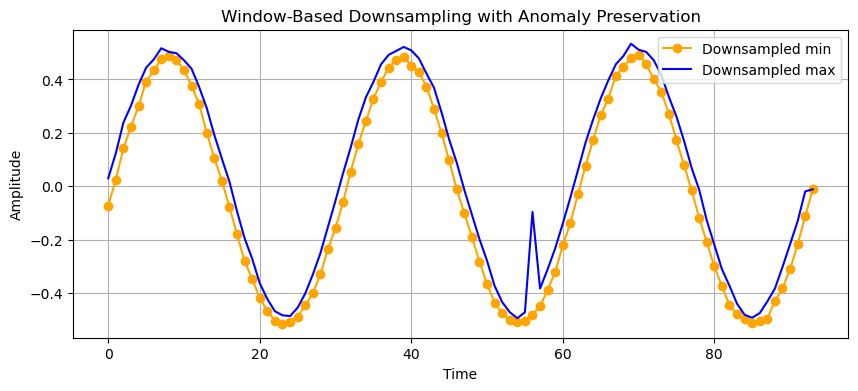

In [13]:
frame_id = 3

plt.figure(figsize=(10, 4))
#plt.plot(x, signal, label="Original (1024)")
plt.plot(training_dataset_min[frame_id], 'o-', color='orange', label=f"Downsampled min")
plt.plot(training_dataset_max[frame_id], '-', color='blue', label=f"Downsampled max")
plt.legend()
plt.title("Window-Based Downsampling with Anomaly Preservation")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

### 3.1 Split the training dataset into training and validation sets.
80/20 split is used in this tutorial.

In [132]:
full_training_dataset = training_dataset_min + training_dataset_max
total_size_full = len(full_training_dataset)
print(total_size_full)

3386


In [144]:
# Find anomaly indices (first 10 from each half)
anomaly_indices = list(range(0, 10)) + list(range(len(training_dataset_min), len(training_dataset_min) + 10))
# All other indices are normal
all_indices = list(range(total_size_full))
normal_indices = [i for i in all_indices if i not in anomaly_indices]


total_size = total_size_full - len(anomaly_indices)
train_size = int(0.8 * total_size)
val_size = total_size - train_size


# Shuffle for random sampling
np.random.shuffle(anomaly_indices)
np.random.shuffle(normal_indices)

# Select anomalies
num_train_anomalies = int(0.8*len(anomaly_indices))
train_anomaly_indices = anomaly_indices[:num_train_anomalies]
val_anomaly_indices = anomaly_indices[num_train_anomalies:num_train_anomalies + num_val_anomalies]

# Select normals
train_normal_indices = normal_indices[:train_size]
val_normal_indices = normal_indices[train_size:]

print(len(train_normal_indices), len(val_normal_indices))

# Combine and shuffle
train_indices = train_anomaly_indices + train_normal_indices
val_indices = val_anomaly_indices + val_normal_indices

np.random.shuffle(train_indices)
np.random.shuffle(val_indices)


print(f"Anomalies in train: {len([i for i in train_indices if i in train_anomaly_indices])}")
print(f"Anomalies in validation: {len([i for i in val_indices if i in val_anomaly_indices])}")

2692 674
Anomalies in train: 16
Anomalies in validation: 4


In [145]:
# Create train and validation datasets with the generated indices
expected_legth = len(full_training_dataset[0])
training_inputs = [full_training_dataset[i] for i in train_indices if len(full_training_dataset[i]) == expected_legth]
validation_inputs = [full_training_dataset[i] for i in val_indices if len(full_training_dataset[i]) == expected_legth]
full_training_dataset = [row for row in full_training_dataset if len(row) == expected_legth]

print(len(full_training_dataset))

3384


## 4. Define the model and train

In [146]:
quant_mod = LinnModel()

In [147]:
# Set up the early stopping - the below checks every 10 epochs 

early_stopping_config = {
    'patience': 10,   # Allow 10 epochs without improvement
    'restore_best_weights': True
}

In [148]:
# model definition for an autoencoder
frame_length = len(training_inputs[0])
print(f"frame length/input dimension: {frame_length}")

# train the model
quant_mod.set_training_data(training_inputs=training_inputs, training_outputs=training_inputs)
model_definition = [(64, 'relu'), (32, 'relu'), (16, 'relu'), (frame_length, 'linear')]

# build the model
#quant_mod.construct_model(model_definition, show_summary=True)
quant_mod.construct_model(model_definition)

frame length/input dimension: 94


In [149]:
history = quant_mod.fit_model(epochs=100, es_config=early_stopping_config, validation_split=0.1)

Value for monitor missing. Using default:val_loss.
Value for restore missing. Using default:False.


Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6600 - val_loss: 0.2538
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1922 - val_loss: 0.0784
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0680 - val_loss: 0.0459
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0453 - val_loss: 0.0396
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0400 - val_loss: 0.0384
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0388 - val_loss: 0.0381
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0383 - val_loss: 0.0380
Epoch 8/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0381 - val_loss: 0.0379
Epoch 9/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0381 - val_loss: 0.0379
Epoch 10/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0379 - val_loss: 0.0379
Epoch 11/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0380 - val_loss: 0.0379
Epoch 12/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

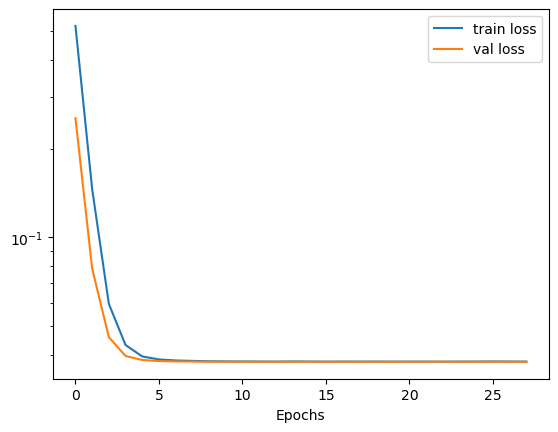

In [150]:
# plot the losses
plt.semilogy(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.xlabel('Epochs')
plt.show()

In [151]:
save_linn(quant_mod, input_channels=1, output_channels=1, file_name='AD_autoencoder_api.linn')

Skipping layer 0 with type <class 'keras.src.layers.core.input_layer.InputLayer'>
Skipping layer 2 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 4 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 6 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 8 with type <class 'moku.nn._linn.OutputClipLayer'>
Network latency approx. 218 cycles


# 5. Testing the model - reconstruct the training dataset
This is used to see how well the model has learnt to reconstruct the data from the training dataset

In [152]:
reconstructions = []
reconstructions = quant_mod.predict(full_training_dataset)

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


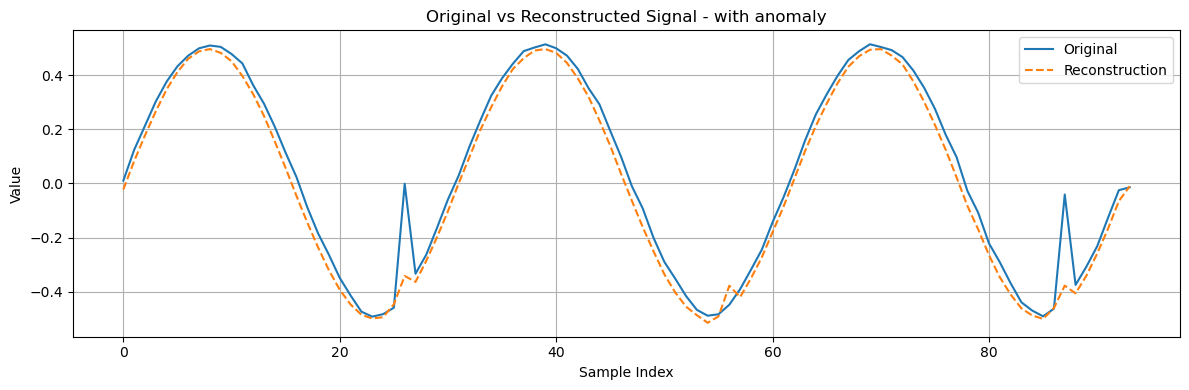

In [153]:
frame_id_anomaly = 1696

plt.figure(figsize=(12, 4))
plt.plot(full_training_dataset[frame_id_anomaly], label='Original')
plt.plot(reconstructions[frame_id_anomaly], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal - with anomaly')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


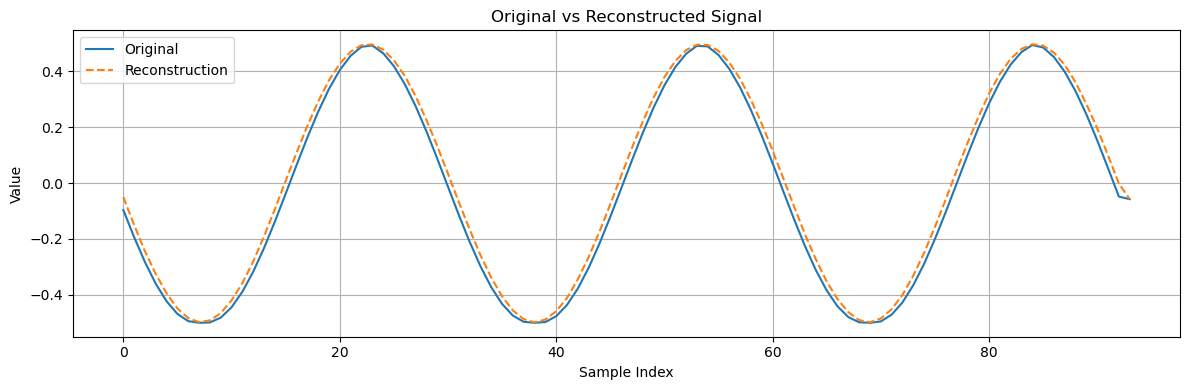

In [154]:
frame_id = 15

plt.figure(figsize=(12, 4))
plt.plot(full_training_dataset[frame_id], label='Original')
plt.plot(reconstructions[frame_id], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


In [155]:
original = np.array(full_training_dataset)
reconstructed = np.array(reconstructions)

# --- Error Calculations ---
# Element-wise absolute error
absolute_error = np.abs(original - reconstructed)

# Element-wise squared error
squared_error = (original - reconstructed) ** 2

# Total error per sample (row-wise)
absolute_error_per_frame = absolute_error.sum(axis=1)
squared_error_per_frame = squared_error.sum(axis=1)


#### Absolute error

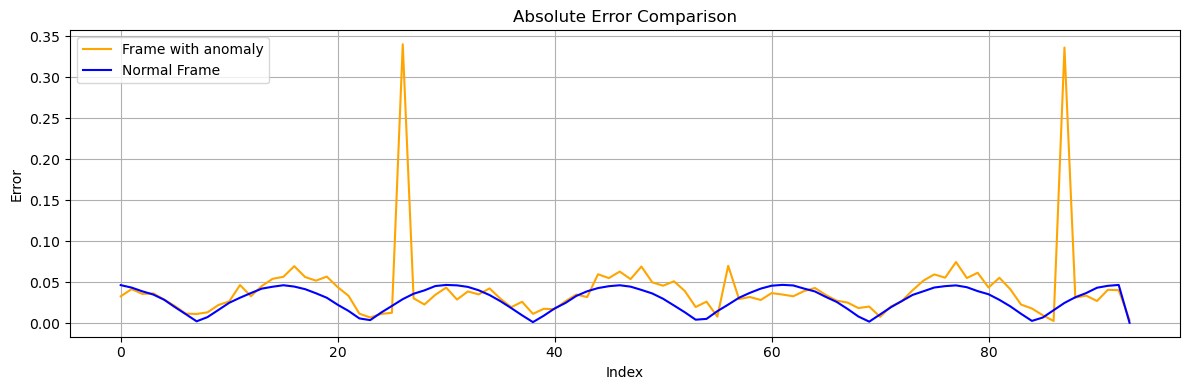

In [156]:

# --- Plotting both frame_ids together ---
plt.figure(figsize=(12, 4))

plt.plot(absolute_error[frame_id_anomaly], label='Frame with anomaly', color='orange')
plt.plot(absolute_error[frame_id], label='Normal Frame', color='blue')

plt.title('Absolute Error Comparison')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [157]:
threshold = 0.15

# Find indices where value > threshold

# Frame with Anomaly
indices = [i for i, v in enumerate(absolute_error[frame_id_anomaly]) if v > threshold]

# Print results
print("Frame with anomaly")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [absolute_error[frame_id_anomaly][i] for i in indices])


print("-------------------------------------------------------------------------------")


# Normal with Anomaly
indices = [i for i, v in enumerate(absolute_error[frame_id]) if v > threshold]

# Print results
print("Normal frame")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [absolute_error[frame_id][i] for i in indices])

Frame with anomaly
Indices of values > threshold: [26, 87]
Corresponding values: [0.34050097960243875, 0.336498509723242]
-------------------------------------------------------------------------------
Normal frame
Indices of values > threshold: []
Corresponding values: []


#### Squared error

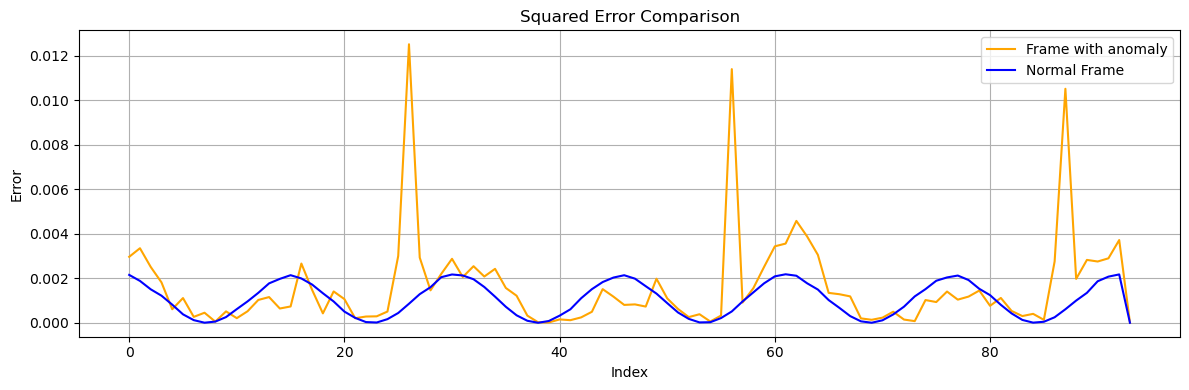

In [158]:
frame_id_anomaly = 0
frame_id = 15

# --- Plotting both frame_ids together ---
plt.figure(figsize=(12, 4))

plt.plot(squared_error[frame_id_anomaly], label='Frame with anomaly', color='orange')
plt.plot(squared_error[frame_id_normal], label='Normal Frame', color='blue')

plt.title('Squared Error Comparison')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [159]:
threshold = 0.008

# Find indices where value > threshold

# Frame with Anomaly
indices = [i for i, v in enumerate(squared_error[frame_id_anomaly]) if v > threshold]

# Print results
print("Frame with anomaly")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [squared_error[frame_id_anomaly][i] for i in indices])


print("-------------------------------------------------------------------------------")


# Normal with Anomaly
indices = [i for i, v in enumerate(squared_error[frame_id]) if v > threshold]

# Print results
print("Normal frame")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [squared_error[frame_id][i] for i in indices])

Frame with anomaly
Indices of values > threshold: [26, 56, 87]
Corresponding values: [0.012517130511444928, 0.01139975718295511, 0.010516321782552643]
-------------------------------------------------------------------------------
Normal frame
Indices of values > threshold: []
Corresponding values: []


### Focal loss

In [160]:
def focal_mse_loss(prediction, target, gamma=2.5):
    error = prediction - target
    squared_error = error ** 2
    loss = squared_error ** gamma
    return loss

In [161]:
# --- Focal Loss Calculation ---
focal_loss = focal_mse_loss(reconstructed, original)  # element-wise focal loss

# Total focal loss per sample (row-wise sum)
focal_loss_per_frame = focal_loss.sum(axis=1)

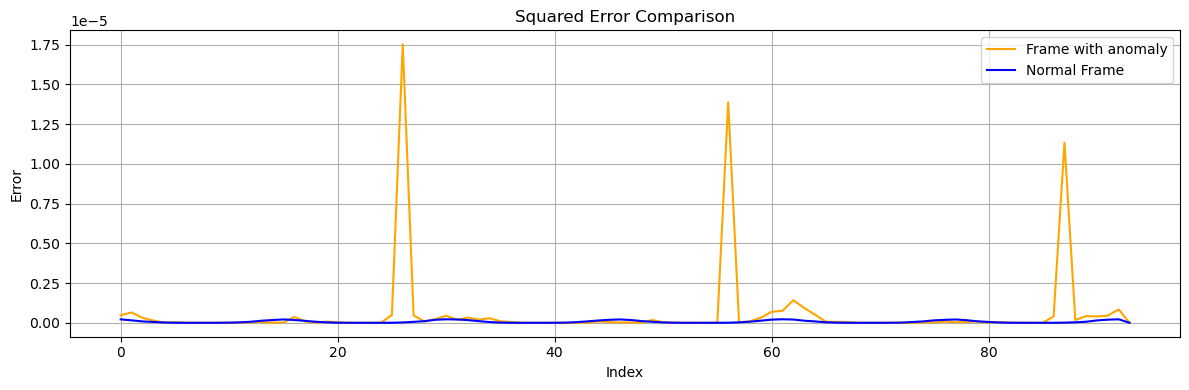

In [162]:
# --- Plotting both frame_ids together ---
plt.figure(figsize=(12, 4))

plt.plot(focal_loss[frame_id_anomaly], label='Frame with anomaly', color='orange')
plt.plot(focal_loss[frame_id], label='Normal Frame', color='blue')

plt.title('Squared Error Comparison')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [163]:
threshold = 0.000006

# Find indices where value > threshold

# Frame with Anomaly
indices = [i for i, v in enumerate(focal_loss[frame_id_anomaly]) if v > threshold]

# Print results
print("Frame with anomaly")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [focal_loss[frame_id_anomaly][i] for i in indices])


print("-------------------------------------------------------------------------------")


# Normal with Anomaly
indices = [i for i, v in enumerate(focal_loss[frame_id]) if v > threshold]

# Print results
print("Normal frame")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [focal_loss[frame_id][i] for i in indices])

Frame with anomaly
Indices of values > threshold: [26, 56, 87]
Corresponding values: [1.7529194149394408e-05, 1.3875192023815455e-05, 1.1341217148195211e-05]
-------------------------------------------------------------------------------
Normal frame
Indices of values > threshold: []
Corresponding values: []
